# Transaction Analysis

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [98]:
import os
os.getcwd()

#if need to change use os.chdir()

'C:\\Users\\Roger\\Desktop\\Jupyter'

In [99]:
#read in data
fraud = pd.read_csv("A2 data.csv")

In [100]:
#basic eda
fraud.head()
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
step           594643 non-null int64
customer       594643 non-null object
age            594643 non-null object
gender         594643 non-null object
zipcodeOri     594643 non-null object
merchant       594643 non-null object
zipMerchant    594643 non-null object
category       594643 non-null object
amount         594643 non-null float64
fraud          594643 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [101]:
fraud.shape
type(fraud)

pandas.core.frame.DataFrame

In [102]:
fraud.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [103]:
#remove zip columns as they have zero variance
fraud.loc[:,["zipMerchant", "zipcodeOri"]]

fraud = fraud.drop(columns=["zipMerchant", "zipcodeOri"]) 

In [104]:
#ensure columns have been dropped
fraud.info()
fraud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
step        594643 non-null int64
customer    594643 non-null object
age         594643 non-null object
gender      594643 non-null object
merchant    594643 non-null object
category    594643 non-null object
amount      594643 non-null float64
fraud       594643 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 36.3+ MB


,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


In [105]:
#remove all quotation marks in columns where they exist
fraud['customer'] = fraud['customer'].str.strip('\'')
fraud['age'] = fraud['age'].str.strip('\'')
fraud['gender'] = fraud['gender'].str.strip('\'')
fraud['merchant'] = fraud['merchant'].str.strip('\'')
fraud['category'] = fraud['category'].str.strip('\'')


In [106]:
#ensure they have been removed
fraud.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [107]:
#check help documentation for astype
fraud.astype?

#double question mark shows the code that was used to create the function
fraud.astype??

In [108]:
#fraud['amount'] = fraud['amount'].astype('float64')
#fraud['customer'] = fraud['customer'].astype('category')
#fraud['fraud'] = fraud['fraud'].astype('category')
#fraud['gender'] = fraud['gender'].astype('category')
#fraud['age'] = fraud['age'].astype('category')
#fraud['merchant'] = fraud['merchant'].astype('category')
#fraud['category'] = fraud['category'].astype('category')
#fraud['fraud'] = fraud['fraud'].astype('category')

#originally was going to do the above but need to change categoricals to numericals so that smote runs
#turning object columns type to categorical for easing the transformation process
col_categorical = fraud.select_dtypes(include= ['object']).columns
for col in col_categorical:
    fraud[col] = fraud[col].astype('category')
#change categorical values to numeric values
fraud[col_categorical] = fraud[col_categorical].apply(lambda x: x.cat.codes)
fraud.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [109]:
#check the types have changed
fraud.info()
fraud.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
step        594643 non-null int64
customer    594643 non-null int16
age         594643 non-null int8
gender      594643 non-null int8
merchant    594643 non-null int8
category    594643 non-null int8
amount      594643 non-null float64
fraud       594643 non-null int64
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 17.0 MB


step          int64
customer      int16
age            int8
gender         int8
merchant       int8
category       int8
amount      float64
fraud         int64
dtype: object

In [110]:
#check the categories within age
fraud.age.unique
fraud["age"].value_counts()

2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
0      2452
7      1178
Name: age, dtype: int64

In [111]:
#check for missing value
fraud.isnull().sum()

step        0
customer    0
age         0
gender      0
merchant    0
category    0
amount      0
fraud       0
dtype: int64

In [112]:
#check for duplicated
fraud.duplicated().sum()

0

In [113]:
fraud.replace?

In [114]:
#originally had recoded as below but unlike r this does not seem to work for the models in python
#recode 0's and 1's to yes and no in outcome variable fraud
#fraud["fraud"] = fraud["fraud"].replace(0, "No")
#fraud["fraud"] = fraud["fraud"].replace(1, "Yes")

In [115]:
#use value_counts() to ensure this has occured
fraud["fraud"].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

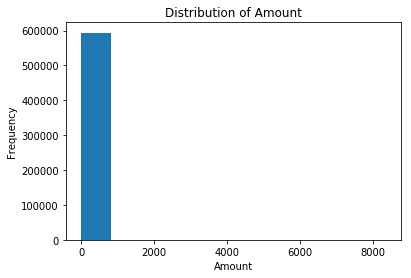

In [116]:
#check the distribution of amount
fraud.plot(kind = 'hist', y = 'amount', legend = False)
plt.title("Distribution of Amount")
plt.xlabel("Amount")
plt.show()

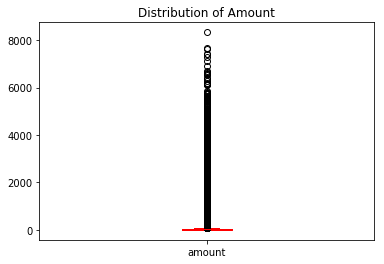

In [117]:
#check the distribution of amount
fraud.plot(kind = 'box', y = 'amount', color = 'r')
plt.title("Distribution of Amount")
plt.show()

In [179]:
#check for transactions of amount 0
fraud['amount'].loc[fraud.amount == 0].count() 
zero_tran = fraud.loc[fraud.amount == 0]

#check if these 52 transactions are fradulent
zero_tran[['fraud','amount']]
type(zero_tran)


pandas.core.frame.DataFrame

In [119]:
fraud.shape

(594643, 8)

In [120]:
#remove the amounts equal to 0
fraud = fraud.loc[fraud.amount != 0]

#check the shape to ensure this has happened
fraud.shape

(594591, 8)

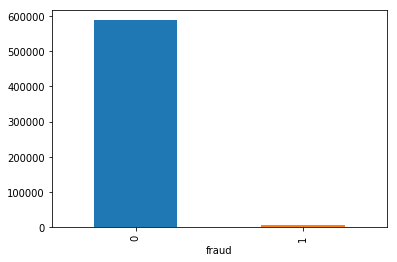

In [121]:
#show the split between fradulent and non fradulent transactions
fraud.groupby('fraud')['fraud'].count().plot(kind = 'bar')

In [122]:
#split independent and dependent variables
X = fraud.drop(['fraud'],axis=1)
y = fraud['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [123]:
#split the data into a training and test splt
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3,random_state=42,shuffle=True,stratify=y)

In [124]:
#check the dimensions of the training and test set
X_train.shape
y_train.shape
X_test.shape
y_test.shape


(178378,)

In [125]:
X_train.head()

,step,customer,age,gender,merchant,category,amount
296036,97,3368,3,1,18,12,44.74
84304,31,3033,3,1,30,12,67.23
220856,75,3719,1,1,18,12,51.51
176168,61,3044,2,2,18,12,35.87
321713,104,84,2,2,45,3,32.72


In [128]:
#use smote to balance training dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(np.bincount(y_res))

[411173 411173]


In [129]:
#Random forest
#train model on training smote data
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [ ]:
#predict the test set values
y_pred = clf_rf.predict(X_test)

In [173]:
#check performance of model
print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
print("ROC Score: \n", roc_auc_score(y_test,y_pred))

#accuracy is not a good measure but leaving code here anyways
print("Accuracy Score: \n", accuracy_score(y_test,y_pred))


#note recall of the positive class is the same as sensitivity (TPR) and recall of the negative rate is the same as specificity (TNR)

Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176218
           1       0.82      0.80      0.81      2160

   micro avg       1.00      1.00      1.00    178378
   macro avg       0.91      0.90      0.90    178378
weighted avg       1.00      1.00      1.00    178378

Confusion Matrix of Random Forest Classifier: 
 [[175824    394]
 [   423   1737]]
ROC Score: 
 0.9009653998645616
Accuracy Score: 
 0.9954198387693549


In [ ]:
#check feature importance of model
print(clf_rf.feature_importances_)

plt.bar(range(len(clf_rf.feature_importances_)), clf_rf.feature_importances_)
plt.show()
